# Basics of Hidden Markov Models

In this notebook we review two basic tasks related to Hidden Markov Models (**HMM**):
* finding marginal probabilities
* finding the most probable outcome

We defer the parameter estimation to later lectures where we'll discuss expectation maximisation algorithm

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import string

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I.  Why parameter estimation is difficult for HMM

<img src = 'illustrations/hidden-markov-model.pdf' width=100%>

If the sequence of states $x_1,x_2,\ldots$ is known for all sequences of observations $y_1,y_2,\ldots$, we can estimate the initial probabilities $\boldsymbol{\beta}[\cdot]$ and transition probabilities $\boldsymbol{\alpha}[\cdot,\cdot]$ using methods for Markov chains and the emission probabilities $\boldsymbol{\delta}[\cdot,\cdot]$ using methods from dice throwing analysis.
However, in most cases the sequence of states $x_1,x_2,\ldots$ is unknown and this makes the analysis much harder. 

In the following, we consider an HMM model for words that takes typing errors into account. Let $x_i$ denote the intended characters and $y_i$ typed characters. 
Then the most naive way of modelling typing errors is that with $1-\rho=98\%$ probability we type the intended character and with $\rho=2\%$ we type a random character:

\begin{align*}
\boldsymbol{\delta}[x,y]=
\begin{cases}
1-\rho\cdot\frac{m-1}{m}, &\text{if } x=y,\\
\frac{\rho}{m}, &\text{if } x\neq y
\end{cases}\enspace.
\end{align*}

To estimate parameters $\boldsymbol{\beta}$ and transition probabilities $\boldsymbol{\alpha}$, we use the same data and methodology we used for the first notebook about Markov chains with the exception that we use maximum likelihood estimates instead of Lapace smoothing, as we explicitly model typing errors in the HMM.  

### Preprocessing

As a practical engineering trick we convert all character to lower case and map all values outside the range `0-9a-z` to the symbol `?`, which will represent all characters we do not want to treat. For obvious reasons, this approach is valid only for English tests.

In [2]:
df = pd.read_csv('data/eng_training_set.csv', header=None, names=['words'])
old = head(df)
df['words'] = df['words'].str.lower().str.replace('[^0-9a-z]','?')
mdisplay([old, head(df)],['Initial data', 'Processed data'])

Initial data Processed data 
 
 
 words 
 
 
 
 
 friendship 
 
 
 guess 
 
 
 accounts 
 
 
 it?s 
 
 
 me 
 
 
 
 
 
 words 
 
 
 
 
 friendship 
 
 
 guess 
 
 
 accounts 
 
 
 it?s 
 
 
 me

### Counts of starting letters and bigrams

In [6]:
start_counts = (DataFrame(df['words'].str.lower()
                          .str[0].value_counts())
                .reset_index()
                .rename(columns = {'index': 'u1', 'words': 'count'})
                .set_index(['u1']))

bigram_counts = (DataFrame(
                    Series(
                        df['words'].str.lower()
                        .apply(ngrams).sum())
                    .value_counts())
                 .rename(columns = {0: 'count'})
                 .assign(u1 = lambda df: Series(df.index.values).str[0].to_list())
                 .assign(u2 = lambda df: Series(df.index.values).str[1].to_list())
                 .set_index(['u1', 'u2'])
                 )

mdisplay([head(start_counts.reset_index()), head(bigram_counts.reset_index())], ['Start counts', 'Bigram counts'] )

Start counts Bigram counts 
 
 
 u1 
 count 
 
 
 
 
 t 
 164 
 
 
 a 
 101 
 
 
 i 
 92 
 
 
 w 
 72 
 
 
 s 
 63 
 
 
 
 
 
 u1 
 u2 
 count 
 
 
 
 
 t 
 h 
 126 
 
 
 h 
 e 
 86 
 
 
 i 
 n 
 75 
 
 
 a 
 n 
 63 
 
 
 r 
 e 
 61

### Maximum likelihood parameter estimates

In [27]:
LetterType = CategoricalDtype(list(string.ascii_lowercase) + list(string.digits) + ['?'], ordered = True)

beta = (start_counts.reindex(LetterType.categories, fill_value=0)
        .rename(columns = {'count': 'pr'})
        .assign(pr = lambda df: df['pr']/df['pr'].sum())
        )

# Index without gaps
midx = pd.MultiIndex.from_product([LetterType.categories.values]*2, names = ['u1', 'u2'])

alpha = (bigram_counts.reindex(midx, fill_value=0).groupby(['u1'])
         .apply(lambda df: df.assign(pr = lambda ddf: ddf['count']/ddf['count'].sum()))
         .fillna(0)
         [['pr']]) 

mdisplay([head(beta.reset_index()), head(alpha.reset_index())], ['beta', 'alpha'])

beta alpha 
 
 
 index 
 pr 
 
 
 
 
 a 
 0.101 
 
 
 b 
 0.048 
 
 
 c 
 0.041 
 
 
 d 
 0.027 
 
 
 e 
 0.025 
 
 
 
 
 
 u1 
 u2 
 pr 
 
 
 
 
 a 
 a 
 0.000000 
 
 
 a 
 b 
 0.034700 
 
 
 a 
 c 
 0.037855 
 
 
 a 
 d 
 0.047319 
 
 
 a 
 e 
 0.000000

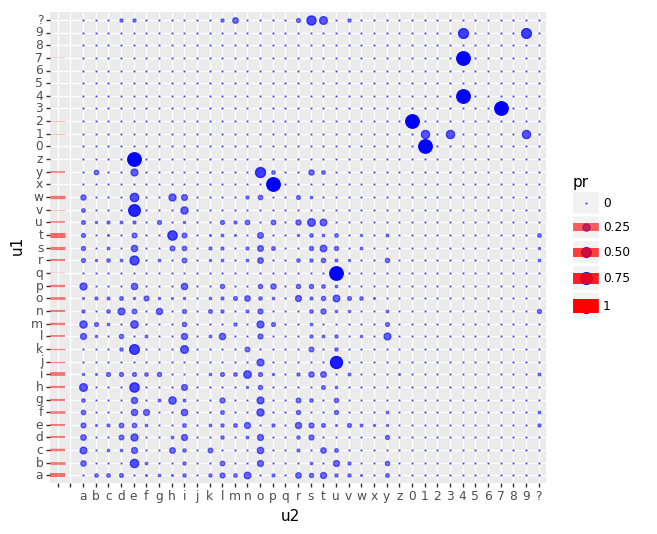

<ggplot: (-9223372029303537166)>

In [38]:
LetterType2 = CategoricalDtype([' ', '  '] + list(string.ascii_lowercase) + list(string.digits) + ['?'], ordered = True)

p = ggplot(alpha
           .reset_index()
           .assign(u1 = lambda df: df['u1'].astype(LetterType2))
           .assign(u2 = lambda df: df['u2'].astype(LetterType2)))
p = p + geom_point(aes(x = 'u2', y = 'u1', size = 'pr',  alpha = 'pr'), color =  'blue')
p = p + geom_rug(aes(y='index', size='pr', alpha = 'pr'), color = 'red', data = beta.reset_index())
p = p + coord_fixed(ratio = 1)
p = p + scale_x_discrete(drop=False)
p = p + scale_alpha(range=(0.5, 1), limits=(0,1)) 
p = p + scale_size(range=(0, 5))
display(p)

In [39]:
alpha = alpha.unstack('u2').pipe(reset_column_index, level=0).fillna(0)
print(alpha.shape)
display(head(alpha))

(37, 37)


u2,0,1,2,3,4,5,6,7,8,9,...,q,r,s,t,u,v,w,x,y,z
u1,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we must define emission matrix $\boldsymbol{\delta}$.

In [ ]:
m = len(LetterType.categories)
delta = DataFrame(0.02/m,columns = LetterType.categories, index =LetterType.categories)
np.fill_diagonal(delta.values, 1 - 0.02*(m-1)/m) 

In [68]:
head(delta)

,a,b,c,d,e,f,g,h,i,j,...,1,2,3,4,5,6,7,8,9,?
a,0.980541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,...,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541
b,0.000541,0.980541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,...,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541
c,0.000541,0.000541,0.980541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,...,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541
d,0.000541,0.000541,0.000541,0.980541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,...,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541
e,0.000541,0.000541,0.000541,0.000541,0.980541,0.000541,0.000541,0.000541,0.000541,0.000541,...,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541


## II. Likelihood propagation in the tree

Let us use belief propagation to compute marginal probabilities for each missing character in the following sequence of observations: $y_1,y_2,\ldots$.

In [125]:
y = ['d', '-', 'm', '-', '-', '-', 'd', 'o', 'r', '-']

### Setting boundary conditions for the ends of the chain

The only evidence we have is for the variables $y_i$. It is straightforward to define the likelihood for these nodes.

In [130]:
n = len(y)
Lambda = {}
Lambda['x'] = [None] * n
Lambda['y'] = [None] * n

Pi = {}
Pi['x'] = [None] * n
Pi['y'] = [None] * n

Pr = {}
Pr['x'] = [None] * n
Pr['y'] = [None] * n

In [131]:
for i in range(n):
    if y[i] == '-':
        # All outputs are possible
        Lambda['y'][i]= Series(1, index = LetterType.categories)
    else:
        Lambda['y'][i]= Series(0, index = LetterType.categories)
        Lambda['y'][i][y[i]] = 1        

As we do not see the initial state $x_0$, the prior can be initialised with the vector of initial probabilities.

In [132]:
Pi['x'][0] = beta['pr']

### Likelihood propagation in a tree

We must update the likelihood for $x_{n-1},\ldots,x_0$ using the iterative update rule for trees

<img src = 'illustrations/likelihood-propagation-in-tree-i.pdf' width=100%>

that are analogous to the following case:
\begin{align*}
 \lambda_D&=\lambda_1\otimes\lambda_2\\
 \lambda_1&= M_{e|d}\lambda_E\\
 \lambda_2&= M_{f|d}\lambda_F\enspace.
\end{align*}


In [133]:
Lambda['x'][n-1] = delta.dot(Lambda['y'][n-1])

for i in reversed(range(n-1)):
    l1 = delta.dot(Lambda['y'][i])
    l2 = alpha.dot(Lambda['x'][i+1])
    Lambda['x'][i] = l1 * l2

## III. Belief propagation in a tree

The shape of HMM allows us to send beliefs forward as we can first compute marginal posterior with the scheme

<img src = 'illustrations/prior-propagation-in-tree-i.pdf' width=100%>

\begin{align*}
p_A\propto \pi_A\otimes\lambda_A
\end{align*}

and then update the prior for the next node with the scheme

<img src = 'illustrations/prior-propagation-in-tree-i.pdf' width=100%>

\begin{align*}
\lambda_1 &= M_{b|a}\lambda_B\\
\lambda_2 &= M_{c|a}\lambda_C\\
\pi &= \pi_A M_{d|a}\\
\pi_D&\propto \pi \otimes \lambda_1\otimes \lambda_2.
\end{align*}


In [134]:
for i in range(1, n):
    
    # Update marginal for the previous node
    Pr['x'][i-1] = Pi['x'][i-1] * Lambda['x'][i-1]
    Pr['x'][i-1] = Pr['x'][i-1]/Pr['x'][i-1].sum()
    
    # Update prior for the current node
    l1 = delta.dot(Lambda['y'][i-1])
    pi = Pi['x'][i-1].dot(alpha)
    Pi['x'][i] = pi * l1 
    Pi['x'][i] = Pi['x'][i]/Pi['x'][i].sum()

# Handling the last marginal probability
Pr['x'][n-1] = Pi['x'][n-1] * Lambda['x'][n-1]
Pr['x'][n-1] = Pr['x'][n-1]/Pr['x'][n-1].sum()

### Visualisation

In [137]:
df = (DataFrame(DataFrame(Pr['x']).T.stack())
      .reset_index()
      .rename(columns={'level_0': 'u', 'level_1': 'i', 0: 'pr'}))
head(df)

,u,i,pr
0,0,0,0.000000e+00
1,0,1,3.626721e-12
2,0,2,0.000000e+00
3,0,3,0.000000e+00
4,0,4,0.000000e+00


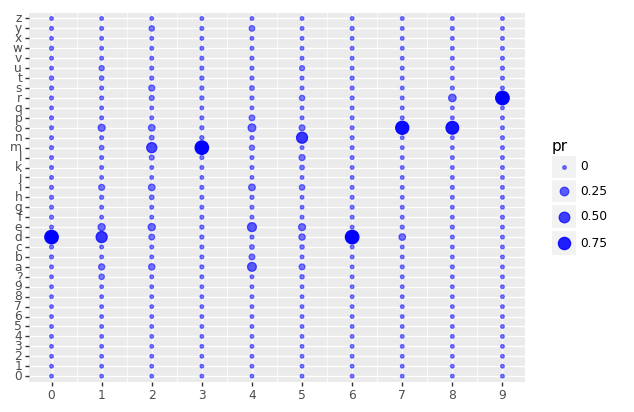

<ggplot: (-9223372029303699084)>

In [138]:
p = ggplot(df)
p = p + geom_point(aes(x = 'i', y = 'u', size = 'pr', alpha = 'pr'), color = 'blue')
p = p + scale_x_continuous(name='',breaks=list(range(n)))
p = p + scale_y_discrete(name='', drop=False)
p = p + scale_alpha(range=(0.5, 1)) 
p = p + scale_size(range=(1, 5))
display(p)

# Homework

## 2.1 Function for imputing missing characters (<font color ='red'>3p</font>)

Define a function `impute_characters_1(x:str)` that imputes missing characters in words using belief propagation and outputs the last figure showing marginal posterior distributions for each location together with the maximum aposteriori estimate.
Test it on four different words with missing characters. 

**Hint:** For getting the maximum aposteriori estimate you have to generalise the appoach that was used in the previous notebook about Markov chains.

**Grading:** You get <font color='red'>1p</font> for the treatment of marginal posterior probabilities and  <font color='red'>2p</font> for the maximum aposteriori estimate.

## 2.2 Language detection with Hidden Markov Models (<font color='red'>1p</font>)

Use files `est_training_set.csv` and `eng_training_set.csv` in the directory `data` to learn model parameters $\alpha$ and $\beta$ for homogenous Markov chains. Use the emission probabilities $\boldsymbol{\delta}$ specified above to get the full parametrisation of HMM.

Put these parameters into the formal model to compute probabilities

\begin{align*}
      p_1 &=\Pr[word|\mathsf{Estonian}]\\
      p_2 &=\Pr[word|\mathsf{English}]
\end{align*}

and then use Bayes formula

\begin{align*}
 \Pr[\mathsf{Estonian}|word]
 =\frac{\Pr[word|\mathsf{Estonian}]\Pr[\mathsf{Estonian}]}{\Pr[word]}
\end{align*}
to guess the language of a word on test samples `est_test_set.csv` and `eng_test_set.csv`.
Why does the procedure work if you use maximum likelihood estimates for the parameters? 
